In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PyTorch Requirements
import torch
import torch.nn as nn
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

%matplotlib inline

In [2]:
# Load and prepare data
data = pd.read_csv("../../data/cyclohexane.csv", header=0)

# raw data and best sample
X = data.drop("solvent", axis=1)
best_sample = X.iloc[0].to_numpy().reshape(-1, 1)

## Visualise raw data

In [3]:
plt.rcParams['font.size'] = 12
xticks = np.linspace(0, X.shape[1]-1, 10, dtype=int)
xlabels = X.columns[xticks].astype(float).astype(int).values

def build_plot():
    fig, ax = plt.subplots(figsize=(8, 4))
    plt.gca().spines['right'].set_color('none')
    plt.gca().spines['top'].set_color('none')
    plt.ylabel("Intensity (a.u)")
    plt.xlabel("Raman Shift (cm$^{-1}$)")
    plt.xlim([-20, 3296])
    plt.xticks(xticks, labels=xlabels)
    plt.grid(False)
    
    return fig

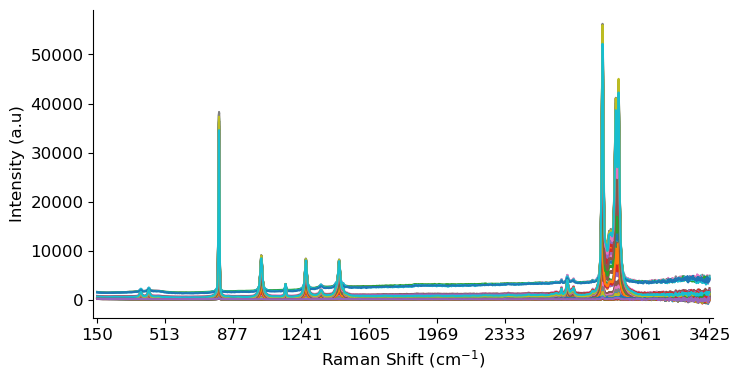

In [4]:
# Raw Spectra
_ = build_plot()
plt.plot(X.T);

## Define required functions

In [5]:
# First we need a custom Torch tensor Dataset to load in the data
class CyclohexaneDataTensor(Dataset):
    def __init__(self, data_X: Tensor, transform_list=None):
        """
        Initialises object and performs data transformation if desired
        
        Args:
            data_X (array-like):
                Spectral data matrix (NumPy array or PyTorch Tensor).
            transform_list (list):
                List of transformations to apply to data (e.g., normalizing, scaling).

        """
        if not isinstance(data_X, (np.ndarray, Tensor)):
            raise TypeError("data_X must be a NumPy array or PyTorch tensor")
            
        self.X_tensor = torch.as_tensor(data_X, dtype=torch.float32)
        self.transforms = transform_list

    def __getitem__(self, index) -> Tensor:
        x = self.X_tensor[index].clone()

        if self.transforms:
            for transform in self.transforms:
                x = transform(x)
        return x

    def __len__(self) -> int:
        return self.X_tensor.size(0)

# function to visualise samples as the model trains and progresses
def draw_synthetic_sample(model: nn.Module, epoch: int, sample_shape: int):
    """
    Function that takes in the generator, generates a sample and plots it.

    Args:
        model (nn.Module):
            Generator model.
        epoch (int):
            current epoch in training.
        noise_input (array-like):
            initial noise to feed forward
    """
    model.eval()

    # `detach` to remove from graph and no gradients computed
    noise = torch.randn(4, Z_DIM, device=DEVICE).detach()
    z_samples = model(noise).detach().cpu() # move to CPU for visualisation

    # loop N samples
    for i in range(z_samples.size(0)):
        plt.figure()
        plt.plot(z_samples[i].numpy().reshape(sample_shape))
        plt.show()

In [6]:
# Define separate models so we can save the Generator and discard the Discriminator later
class Generator(nn.Module):
    """
    Generator for 1D Raman signals
    Progressive convoutional upsampling until signal dimensionality is matched
    """
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            
            nn.Linear(in_features=128, out_features=256),
            nn.ReLU(),

            nn.Linear(in_features=256, out_features=512),
            nn.ReLU(),

            nn.Linear(in_features=512, out_features=1024),
            nn.ReLU(),
            
            nn.Linear(in_features=1024, out_features=2048),
            nn.ReLU(),
            
            nn.Linear(in_features=2048, out_features=3276)
        )

    def forward(self, x: Tensor) -> Tensor:
        # for layer in self.main:
        #     print(x.size())
        #     x = layer(x)
        # return x
        return self.main(x)

class Discriminator(nn.Module):
    """
    Discriminator for classfying real vs fake 1D Raman signals
    Outputs single scalar probability
    """
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            
            nn.Linear(in_features=3276, out_features=2048),
            nn.LeakyReLU(),

            nn.Linear(in_features=2048, out_features=1024),
            nn.LeakyReLU(),

            nn.Linear(in_features=1024, out_features=512),
            nn.LeakyReLU(),

            nn.Linear(in_features=512, out_features=256),
            nn.LeakyReLU(),

            nn.Linear(in_features=256, out_features=128),
            nn.LeakyReLU(),

            nn.Linear(in_features=128, out_features=64),
            nn.LeakyReLU(),

            nn.Linear(in_features=64, out_features=1),            
            # nn.Sigmoid() # remove to use BCELossWithLogits (more numerically stable)
        )
        
    def forward(self, x: Tensor) -> Tensor:
        # for layer in self.main:
        #     print(x.size())
        #     x = layer(x)
        # return x
        return self.main(x)

In [7]:
# Constants and hyperparameters
EPOCHS: int = 27000
BATCH_SIZE: int = 64
Z_DIM: int = 128
SAMPLE_SHAPE: int = X.shape[1]
GLR: float = 2e-3
DLR: float = 2e-4
BETA_1: float = 0.9
BETA_2: float = 0.999
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE}")

# Configure data in Torch Dataset for training
X_copy = X.copy().to_numpy().reshape(-1, SAMPLE_SHAPE)

# load data into Torch Tensor
X_train = CyclohexaneDataTensor(X_copy)
train_loader = DataLoader(X_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

# Define models and send them to active device
generator = Generator().to(DEVICE)
discriminator = Discriminator().to(DEVICE)

# define our loss function and optimisers
loss_fn = nn.BCEWithLogitsLoss().to(DEVICE)
opt_G = torch.optim.Adam(generator.parameters(), lr=GLR, betas=(BETA_1, BETA_2))
opt_D = torch.optim.Adam(discriminator.parameters(), lr=DLR, betas=(BETA_1, BETA_2))

Training on cuda:0


Epoch:[1/27000] 	Batch:[1/3] 	Loss_D:2.2510 	Loss_G:0.6575 	D(x):-3.4823 	D(G(z)):0.0726
Epoch:[1/27000] 	Batch:[2/3] 	Loss_D:0.3965 	Loss_G:0.6550 	D(x):15.4288 	D(G(z)):0.0777
Epoch:[1/27000] 	Batch:[3/3] 	Loss_D:0.3787 	Loss_G:0.6343 	D(x):34.3871 	D(G(z)):0.1214
Epoch:[2/27000] 	Batch:[1/3] 	Loss_D:0.4290 	Loss_G:0.5606 	D(x):55.8687 	D(G(z)):0.2854
Epoch:[2/27000] 	Batch:[2/3] 	Loss_D:0.6102 	Loss_G:0.4027 	D(x):75.8513 	D(G(z)):0.7026
Epoch:[2/27000] 	Batch:[3/3] 	Loss_D:1.1274 	Loss_G:0.2319 	D(x):62.4919 	D(G(z)):1.3532
Epoch:[3/27000] 	Batch:[1/3] 	Loss_D:2.1204 	Loss_G:0.1219 	D(x):71.9706 	D(G(z)):2.0644
Epoch:[3/27000] 	Batch:[2/3] 	Loss_D:2.8712 	Loss_G:0.1487 	D(x):64.2921 	D(G(z)):1.8433
Epoch:[3/27000] 	Batch:[3/3] 	Loss_D:2.6026 	Loss_G:1.5371 	D(x):30.6032 	D(G(z)):-1.2925
Epoch:[4/27000] 	Batch:[1/3] 	Loss_D:0.4210 	Loss_G:4.8191 	D(x):10.9450 	D(G(z)):-4.8100
Epoch:[4/27000] 	Batch:[2/3] 	Loss_D:1.6792 	Loss_G:2.0277 	D(x):-3.1383 	D(G(z)):-1.8836
Epoch:[4/27000] 	B

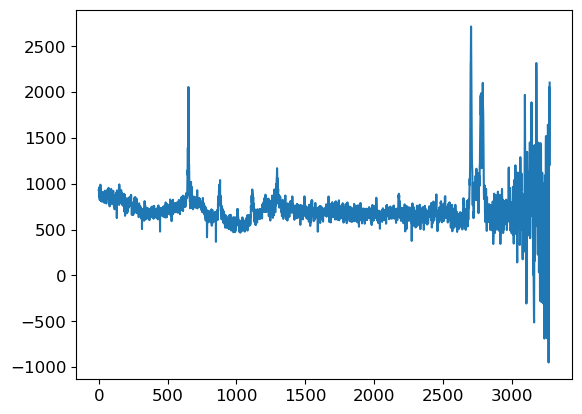

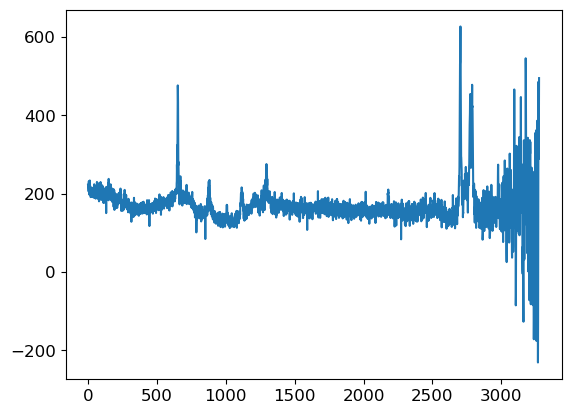

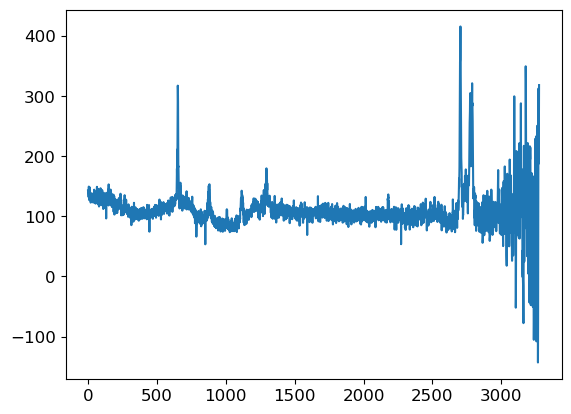

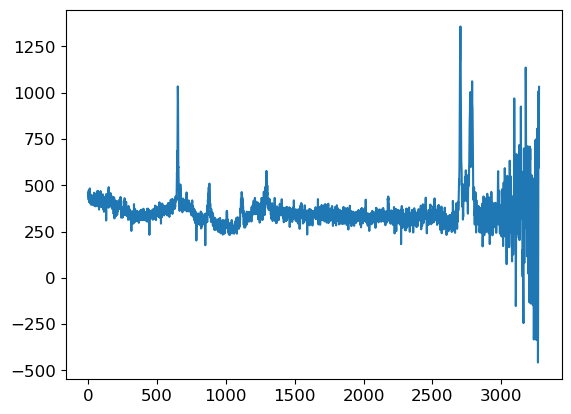

Epoch:[5001/27000] 	Batch:[1/3] 	Loss_D:0.5647 	Loss_G:1.2199 	D(x):1196.3689 	D(G(z)):-0.8641
Epoch:[5001/27000] 	Batch:[2/3] 	Loss_D:0.5694 	Loss_G:1.3104 	D(x):934.6515 	D(G(z)):-0.9873
Epoch:[5001/27000] 	Batch:[3/3] 	Loss_D:0.5261 	Loss_G:1.4846 	D(x):1522.1429 	D(G(z)):-1.2201
Epoch:[5002/27000] 	Batch:[1/3] 	Loss_D:0.5349 	Loss_G:1.4170 	D(x):1031.1436 	D(G(z)):-1.1219
Epoch:[5002/27000] 	Batch:[2/3] 	Loss_D:0.5426 	Loss_G:1.4485 	D(x):1461.9202 	D(G(z)):-1.1572
Epoch:[5002/27000] 	Batch:[3/3] 	Loss_D:0.6037 	Loss_G:1.5857 	D(x):256.8181 	D(G(z)):-1.3458
Epoch:[5003/27000] 	Batch:[1/3] 	Loss_D:0.5288 	Loss_G:1.6114 	D(x):1190.9579 	D(G(z)):-1.3677
Epoch:[5003/27000] 	Batch:[2/3] 	Loss_D:0.6073 	Loss_G:1.6797 	D(x):1102.7078 	D(G(z)):-1.4449
Epoch:[5003/27000] 	Batch:[3/3] 	Loss_D:0.5682 	Loss_G:1.5470 	D(x):1111.3411 	D(G(z)):-1.2946
Epoch:[5004/27000] 	Batch:[1/3] 	Loss_D:0.6112 	Loss_G:1.4589 	D(x):923.9034 	D(G(z)):-1.1830
Epoch:[5004/27000] 	Batch:[2/3] 	Loss_D:0.5965 	Loss_

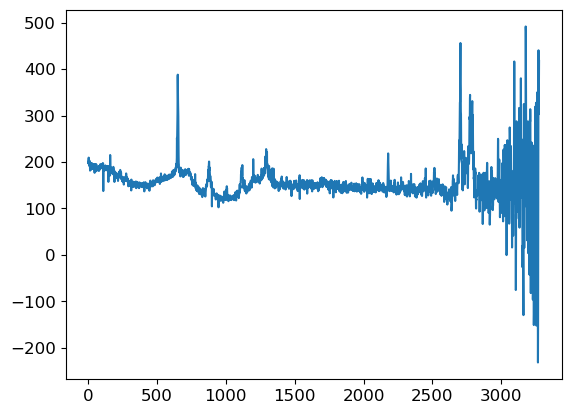

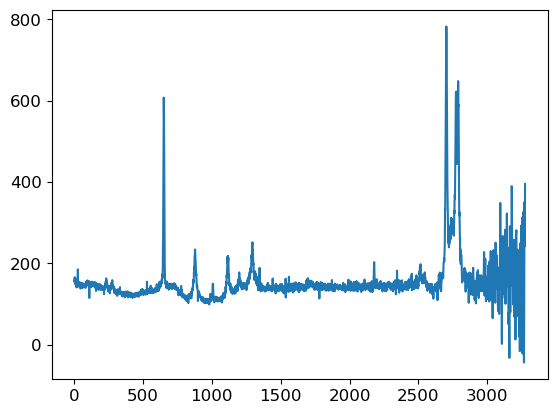

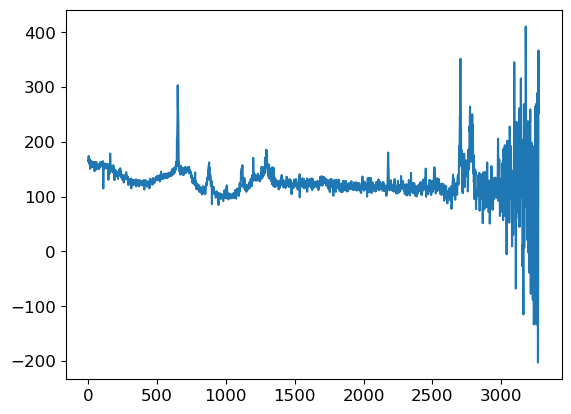

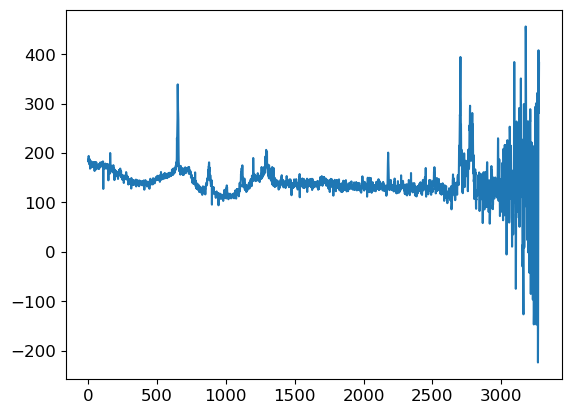

Epoch:[10001/27000] 	Batch:[1/3] 	Loss_D:0.5684 	Loss_G:1.0531 	D(x):6962.9253 	D(G(z)):-0.6197
Epoch:[10001/27000] 	Batch:[2/3] 	Loss_D:0.5450 	Loss_G:0.9775 	D(x):9223.9004 	D(G(z)):-0.4865
Epoch:[10001/27000] 	Batch:[3/3] 	Loss_D:0.5045 	Loss_G:0.8553 	D(x):17980.1211 	D(G(z)):-0.2969
Epoch:[10002/27000] 	Batch:[1/3] 	Loss_D:0.6031 	Loss_G:0.8114 	D(x):5051.4463 	D(G(z)):-0.2103
Epoch:[10002/27000] 	Batch:[2/3] 	Loss_D:0.5333 	Loss_G:0.8871 	D(x):12334.1035 	D(G(z)):-0.3258
Epoch:[10002/27000] 	Batch:[3/3] 	Loss_D:0.5407 	Loss_G:0.9646 	D(x):12679.1807 	D(G(z)):-0.4528
Epoch:[10003/27000] 	Batch:[1/3] 	Loss_D:0.5857 	Loss_G:0.8602 	D(x):5467.8042 	D(G(z)):-0.3067
Epoch:[10003/27000] 	Batch:[2/3] 	Loss_D:0.5404 	Loss_G:0.8829 	D(x):12008.4727 	D(G(z)):-0.3435
Epoch:[10003/27000] 	Batch:[3/3] 	Loss_D:0.6282 	Loss_G:0.8635 	D(x):11759.3301 	D(G(z)):-0.3120
Epoch:[10004/27000] 	Batch:[1/3] 	Loss_D:0.6103 	Loss_G:0.8257 	D(x):6407.3965 	D(G(z)):-0.2411
Epoch:[10004/27000] 	Batch:[2/3] 	L

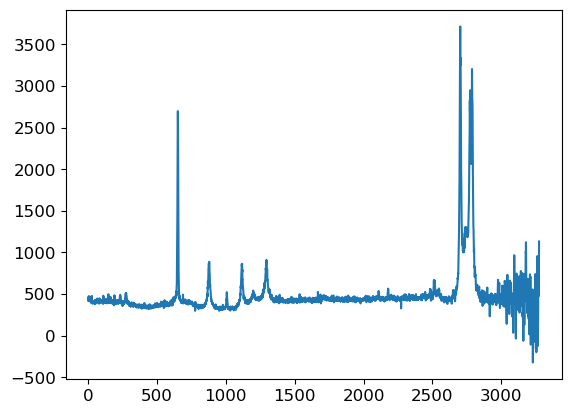

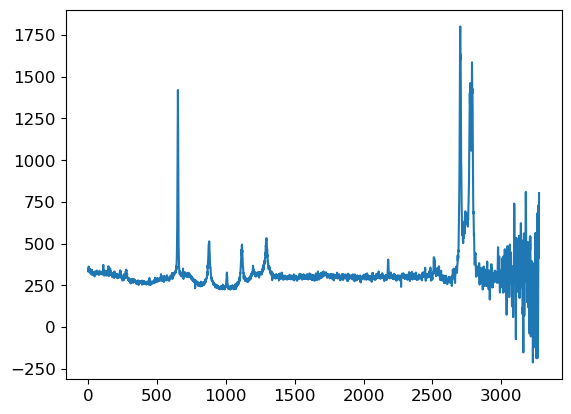

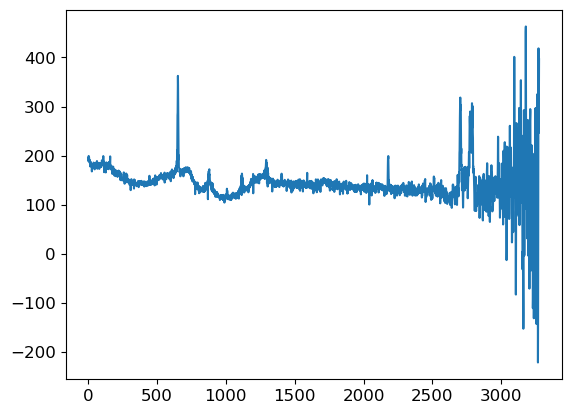

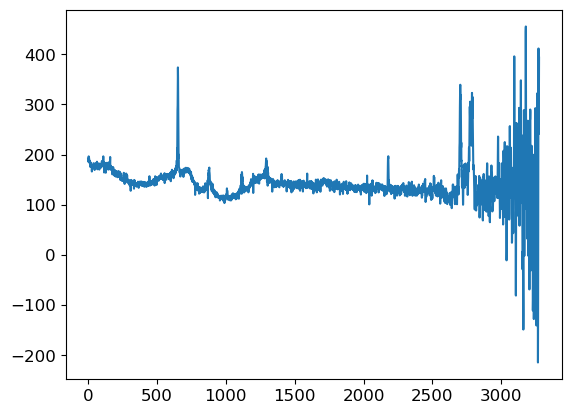

Epoch:[15001/27000] 	Batch:[1/3] 	Loss_D:0.5450 	Loss_G:0.8588 	D(x):1316.6099 	D(G(z)):-0.3057
Epoch:[15001/27000] 	Batch:[2/3] 	Loss_D:0.5935 	Loss_G:0.8611 	D(x):1063.2015 	D(G(z)):-0.3108
Epoch:[15001/27000] 	Batch:[3/3] 	Loss_D:0.6890 	Loss_G:0.8688 	D(x):306.8808 	D(G(z)):-0.3247
Epoch:[15002/27000] 	Batch:[1/3] 	Loss_D:0.5796 	Loss_G:0.8677 	D(x):1253.1350 	D(G(z)):-0.3223
Epoch:[15002/27000] 	Batch:[2/3] 	Loss_D:0.6027 	Loss_G:0.8742 	D(x):647.6012 	D(G(z)):-0.3332
Epoch:[15002/27000] 	Batch:[3/3] 	Loss_D:0.5259 	Loss_G:0.8857 	D(x):2076.4404 	D(G(z)):-0.3539
Epoch:[15003/27000] 	Batch:[1/3] 	Loss_D:0.5882 	Loss_G:0.8756 	D(x):883.4945 	D(G(z)):-0.3360
Epoch:[15003/27000] 	Batch:[2/3] 	Loss_D:0.5893 	Loss_G:0.8798 	D(x):1181.1948 	D(G(z)):-0.3434
Epoch:[15003/27000] 	Batch:[3/3] 	Loss_D:0.5299 	Loss_G:0.8858 	D(x):1435.2283 	D(G(z)):-0.3537
Epoch:[15004/27000] 	Batch:[1/3] 	Loss_D:0.5710 	Loss_G:0.8879 	D(x):1176.0813 	D(G(z)):-0.3572
Epoch:[15004/27000] 	Batch:[2/3] 	Loss_D:0.

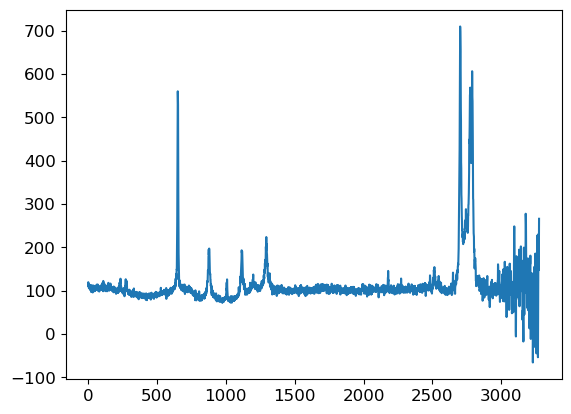

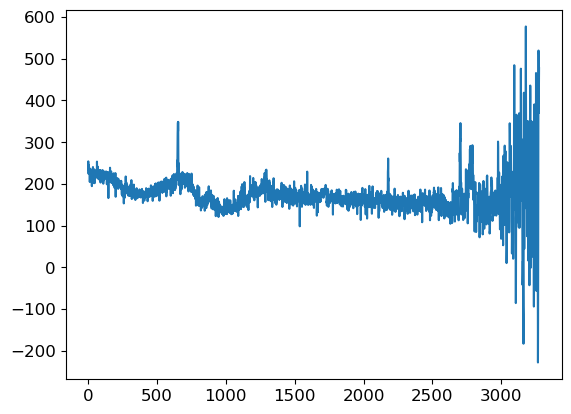

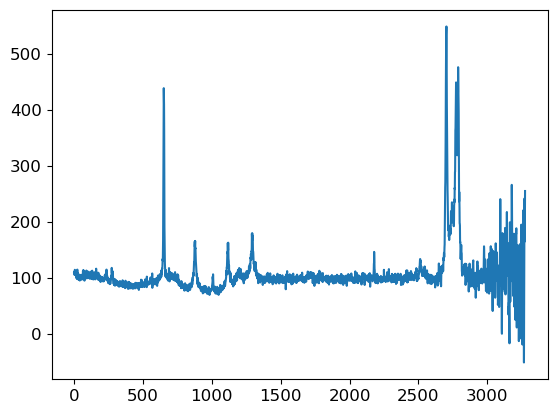

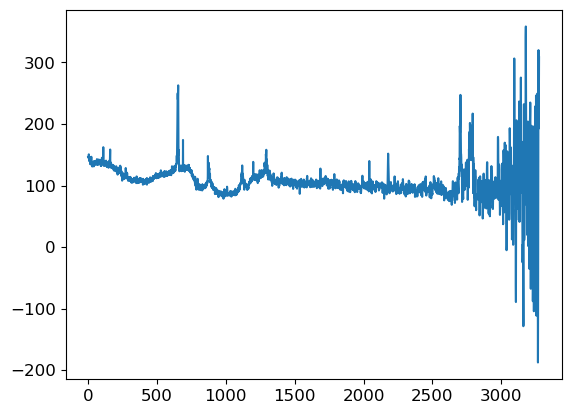

Epoch:[20001/27000] 	Batch:[1/3] 	Loss_D:0.4817 	Loss_G:0.7504 	D(x):27226.4883 	D(G(z)):-0.0909
Epoch:[20001/27000] 	Batch:[2/3] 	Loss_D:0.5387 	Loss_G:0.7246 	D(x):33738.7031 	D(G(z)):-0.0189
Epoch:[20001/27000] 	Batch:[3/3] 	Loss_D:0.4884 	Loss_G:0.7717 	D(x):29357.7578 	D(G(z)):-0.1266
Epoch:[20002/27000] 	Batch:[1/3] 	Loss_D:0.5274 	Loss_G:0.7228 	D(x):17181.6172 	D(G(z)):-0.0369
Epoch:[20002/27000] 	Batch:[2/3] 	Loss_D:0.5503 	Loss_G:0.6693 	D(x):38412.6250 	D(G(z)):0.0725
Epoch:[20002/27000] 	Batch:[3/3] 	Loss_D:0.5200 	Loss_G:0.6878 	D(x):48931.7539 	D(G(z)):0.0510
Epoch:[20003/27000] 	Batch:[1/3] 	Loss_D:0.5654 	Loss_G:0.7365 	D(x):23379.4570 	D(G(z)):-0.0353
Epoch:[20003/27000] 	Batch:[2/3] 	Loss_D:0.5329 	Loss_G:0.7043 	D(x):31029.8438 	D(G(z)):-0.0021
Epoch:[20003/27000] 	Batch:[3/3] 	Loss_D:0.6341 	Loss_G:0.7258 	D(x):52827.4648 	D(G(z)):-0.0593
Epoch:[20004/27000] 	Batch:[1/3] 	Loss_D:0.5468 	Loss_G:0.8034 	D(x):32764.4121 	D(G(z)):-0.1343
Epoch:[20004/27000] 	Batch:[2/3]

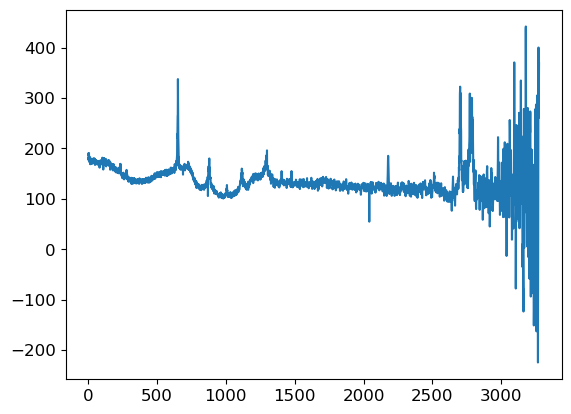

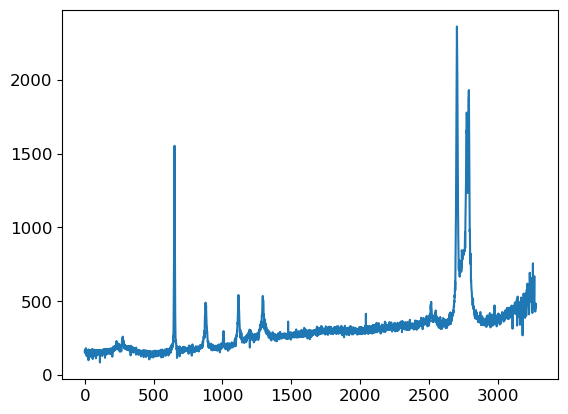

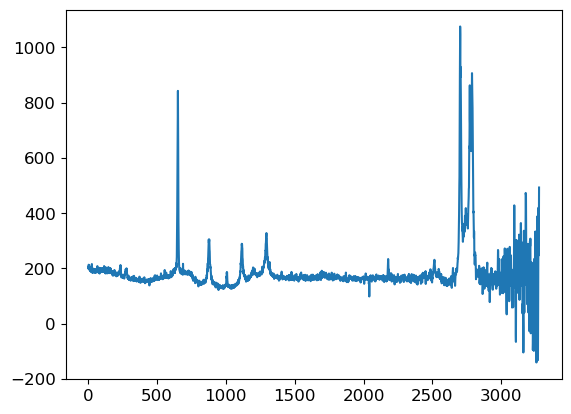

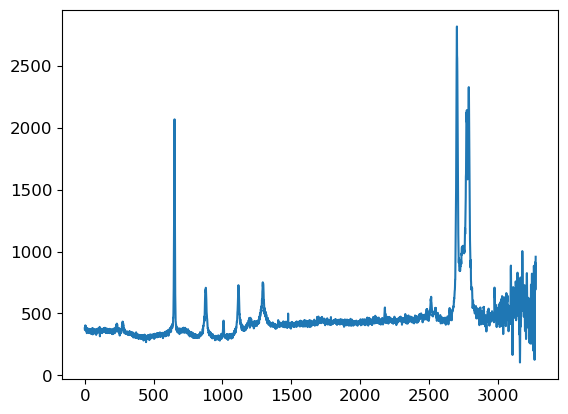

Epoch:[25001/27000] 	Batch:[1/3] 	Loss_D:0.7005 	Loss_G:0.9133 	D(x):16.5718 	D(G(z)):-0.3936
Epoch:[25001/27000] 	Batch:[2/3] 	Loss_D:0.6314 	Loss_G:0.9901 	D(x):18.1400 	D(G(z)):-0.5177
Epoch:[25001/27000] 	Batch:[3/3] 	Loss_D:0.8331 	Loss_G:1.0366 	D(x):11.8910 	D(G(z)):-0.5920
Epoch:[25002/27000] 	Batch:[1/3] 	Loss_D:0.7249 	Loss_G:1.0194 	D(x):16.3195 	D(G(z)):-0.5663
Epoch:[25002/27000] 	Batch:[2/3] 	Loss_D:0.6462 	Loss_G:1.0639 	D(x):15.8843 	D(G(z)):-0.6303
Epoch:[25002/27000] 	Batch:[3/3] 	Loss_D:0.7419 	Loss_G:1.0109 	D(x):14.9452 	D(G(z)):-0.5561
Epoch:[25003/27000] 	Batch:[1/3] 	Loss_D:0.6437 	Loss_G:1.0231 	D(x):13.1068 	D(G(z)):-0.5727
Epoch:[25003/27000] 	Batch:[2/3] 	Loss_D:0.6931 	Loss_G:1.0005 	D(x):19.6035 	D(G(z)):-0.5384
Epoch:[25003/27000] 	Batch:[3/3] 	Loss_D:0.7082 	Loss_G:0.9743 	D(x):23.4146 	D(G(z)):-0.4998
Epoch:[25004/27000] 	Batch:[1/3] 	Loss_D:0.6549 	Loss_G:0.9695 	D(x):21.4730 	D(G(z)):-0.4914
Epoch:[25004/27000] 	Batch:[2/3] 	Loss_D:0.6550 	Loss_G:0.95

In [8]:
############################
# TRAINING
############################
sample_list = []
G_losses = []
D_losses = []

# track training time
start_time = time.time()

# Define training loop
for epoch in range(EPOCHS):
    for batch_idx, batch in enumerate(train_loader):
        itr_batch_size = batch.shape[0]  # Handle varying batch sizes
        
        # Labels
        real_labels = torch.ones((itr_batch_size, 1), dtype=torch.float, device=DEVICE)
        fake_labels = torch.zeros((itr_batch_size, 1), dtype=torch.float, device=DEVICE)
        
        # Real batch input
        real_spectra = batch.to(DEVICE)

        ############################
        # Discriminator
        # Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        opt_D.zero_grad() # reset optimiser each iteration

        # Real spectra predictions
        real_pred = discriminator(real_spectra)
        D_real_loss = loss_fn(real_pred, real_labels) # Loss on real samples
        
        # Generate fake spectra
        z = torch.randn(itr_batch_size, Z_DIM, device=DEVICE)
        fake_spectra = generator(z).detach()  # Detach to prevent Generator gradients

        # Fake spectra predictions
        fake_pred = discriminator(fake_spectra)
        D_fake_loss = loss_fn(fake_pred, fake_labels) # Loss on fake samples

        # Combine real and fake losses
        D_loss = 0.5 * (D_real_loss + D_fake_loss) # average discriminator loss
        D_loss.backward()
        opt_D.step()

        ############################
        # Generator
        # Update G network: maximize log(1 - D(G(z)))
        ###########################
        opt_G.zero_grad() # reset optimiser each iteration

        # Sample noise for generator input, and generate batch of synthetic spectra
        z = torch.randn(itr_batch_size, Z_DIM, device=DEVICE)  # standard normal
        fake_spectra = generator(z)
        fake_pred = discriminator(fake_spectra)
        
        # Generator loss: make discriminator believe fake data is real
        G_loss = loss_fn(fake_pred, real_labels)
        G_loss.backward() # calculate gradients
        opt_G.step() # update model
        
        ############################
        # Logging Scalars
        ############################
        # D(x) should stay close to 1.0 if x is real, and low if it comes from the generator (if using sigmoid output activation)
        D_x = real_pred.mean().item() # average probability prediction over real batch samples (unbounded when using BCELosswithLogits)

        # D(G(z)) is the probability prediction that the output of the generator is real, 
        # it will initially start low but should increase as the Generator improves
        D_G_z = fake_pred.mean().item() # average probability prediction over fake batch samples

        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())

        print(f'Epoch:[{epoch + 1}/{EPOCHS}] \tBatch:[{batch_idx+1}/{len(train_loader)}] \tLoss_D:{D_loss.item():.4f} \tLoss_G:{G_loss.item():.4f} \tD(x):{D_x:.4f} \tD(G(z)):{D_G_z:.4f}')
        
    # Draw some samples
    if (epoch + 1) % 5000 == 0:
        draw_synthetic_sample(generator, epoch + 1, SAMPLE_SHAPE)
        generator.train() # required again if we execute eval() to visualise samples during training

    ############################
    # Checkpointing
    # Checkpoint every few epochs so you can pull out an ideal model before it overfits or suffers mode collapse
    ############################

    # Commented out due to size of files on disk
    if (epoch + 1) % 1000 == 0:
        torch.save({
            "gen_state": generator.state_dict(),
            "dis_state": discriminator.state_dict(),
            "gen_opt_state": opt_G.state_dict(),
            "dis_opt_state": opt_D.state_dict(),
            "epoch": epoch,
            "g_loss": G_loss,
            "d_loss": D_loss
        }, f"./models/gan_checkpoints/gan_checkpoint_epoch_{epoch+1}.tar") # make sure gan_checkpoints folder exists
    
print("GAN took approx: %s minutes" % round((time.time() - start_time) / 60, 4))

## Plot losses

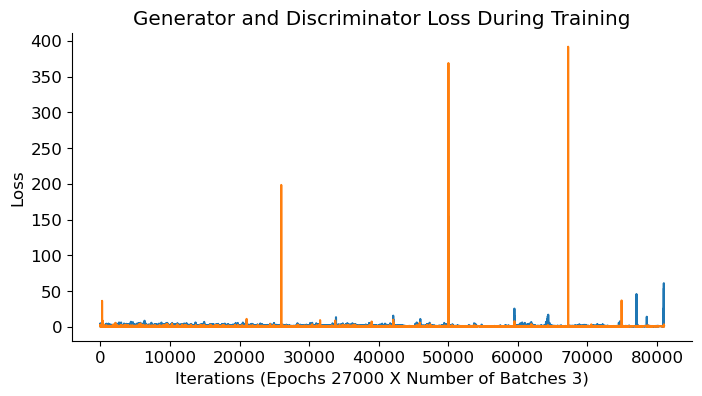

In [9]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.ylabel("Loss")
plt.xlabel(f"Iterations (Epochs {EPOCHS} X Number of Batches {len(train_loader)})")
plt.title("Generator and Discriminator Loss During Training")
plt.grid(False)
plt.plot(G_losses,label="G");
plt.plot(D_losses,label="D");

# Save model to disk

In [10]:
generator_path = "models/fully_connected_gan_generator.pth"
torch.save(generator.state_dict(), generator_path)

# Load model from disk

In [11]:
# define new model
generator = Generator()

# Load the saved weights
generator.load_state_dict(torch.load(generator_path))
generator.to(DEVICE)
generator.eval()

# Generate some samples
noise = torch.randn(1000, 1, Z_DIM, device=DEVICE).detach()
synthetic_samples = generator(noise).detach().cpu().numpy().reshape(-1, 3276)

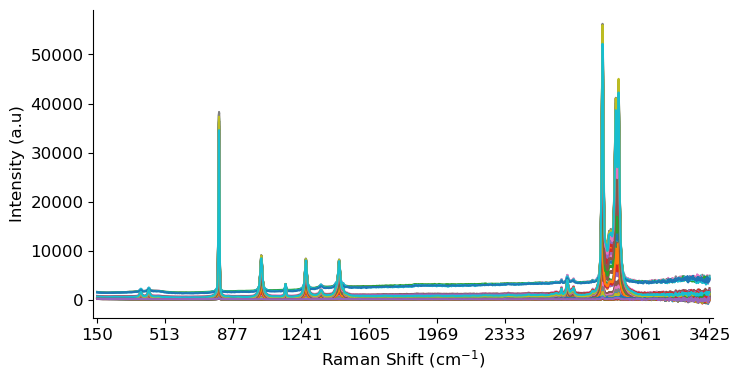

In [12]:
# Original spectra
_ = build_plot()
plt.plot(X.T);

GANs can include a lot of variation, as shown in the synthetic spectra below. This is beneficial for synthetic data where the goal is to include more variation and increase the robustness of deep learning models, however, it also renders GANs notoriously hard to train. This model was trained for 25,000 to 30,000 epochs increasingly with varying batch sizes to determine the best approach. It took some time to produce data that somewhat resembles the real Raman spectra. The magnitude of the synthetic data is still much higher than the original spectra, but it serves the purpose of demonstrating the training procedure and potential benefits of applying to produce synthetic data and augment the spectral data set.

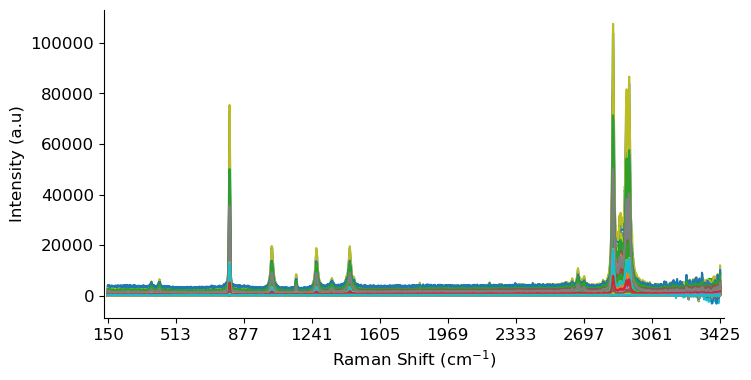

In [13]:
# New Synthetic spectra
_ = build_plot()
plt.plot(synthetic_samples.T);